In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import geopandas as gpd
import warnings
from sklearn.model_selection import RandomizedSearchCV

## Bulid Dataset

In [6]:
data = pd.read_csv('/glade/u/home/dblaskey/RBM/Error_Quantification/error.csv')
data = data[data['type'] == "Optimized_loc"]
data

,Date,sim,obs,COMID,type,DOY
25050,6/8/18,4.76,1.9,81000092,Optimized_loc,159
25051,6/9/18,3.91,2.1,81000092,Optimized_loc,160
25052,6/10/18,3.31,1.7,81000092,Optimized_loc,161
25053,6/11/18,3.69,1.8,81000092,Optimized_loc,162
25054,6/12/18,5.02,2.2,81000092,Optimized_loc,163
...,...,...,...,...,...,...
50095,9/25/21,4.48,4.1,81034272,Optimized_loc,268
50096,9/26/21,4.43,3.8,81034272,Optimized_loc,269
50097,9/27/21,4.10,3.6,81034272,Optimized_loc,270
50098,9/28/21,4.19,3.6,81034272,Optimized_loc,271


In [8]:
#### Begin Code #####
df_sites = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_Basins.csv', index_col=0)
outlets = np.unique(df_sites.outlet_comid.values)

In [44]:
years = range(2017,2022)
start_date = '2017-01-01'
end_date = '2021-09-29'
time_series = pd.date_range(start_date, end_date)

In [58]:
df_list = []

with warnings.catch_warnings(record=True):

    for outlet in outlets:
        Ordered_reaches_final = pd.read_csv("/glade/scratch/dblaskey/RBM/Input/%s_network.csv"%outlet)
        comids = df_sites[df_sites['outlet_comid'] == outlet]['COMID'].values
        site_nos = df_sites[df_sites['outlet_comid'] == outlet].index.values

        for i,comid in enumerate(comids):
            site_no = site_nos[i]
            cell = Ordered_reaches_final[Ordered_reaches_final['hru'] == comid].node.values[-1]

            Water = []
            for year in years:
                test = pd.read_csv("/glade/scratch/dblaskey/RBM/RBM_Input/%s_energy_%s"%(outlet,year), sep=" ", header = None,
                names=["cell", "Tair", "vp", "SW", "LW", "Density","P","Wind"])
                test_id = test[test["cell"] == cell]
                test_id['day'] = range(len(test_id))
                test_id['COMID'] = comid

                Q_df = pd.read_csv("/glade/scratch/dblaskey/RBM/RBM_Input/Production/%s_flow_%s"%(outlet,year), sep=" ", header = None,
                names=["day", "cell", "Q_in", "Q_out", "Q_diff", "depth", "width", "Velocity", "Q_local"])
                Q_df = Q_df[Q_df["cell"] == cell]

                Water.append(test_id.merge(Q_df))

            water_data = pd.concat(Water)

            water_data['Date'] = time_series
            water_data = water_data.set_index('Date')
            df_concat = water_data.loc['2017-10-01':'2021-09-30']
            df_concat = df_concat[df_concat.index.month.isin([5,6,7,8,9])]
            df_concat = df_concat.reset_index()

            df_list.append(df_concat)                     
    warnings.warn("should not appear")
    
input_data = pd.concat(df_list)

## Load Dataset

In [4]:
final_data = pd.read_csv('/glade/u/home/dblaskey/RBM/Error_Quantification/error_final.csv', index_col=0)

#data['Date'] = pd.to_datetime(data['Date'])
#final_data = data.merge(input_data)

final_data['error'] = final_data['sim'] - final_data['obs']

final_df = final_data.drop(columns=['Density', 'Q_out', 'Q_diff', 'Q_local', 'type', 'Date', 'sim', 'obs', 'COMID', 'day'])

In [5]:
final_df

,DOY,cell,Tair,vp,SW,LW,P,Wind,Q_in,depth,width,Velocity,error
0,159,338,-4.5,4.3,0.0472,0.0684,1013.6,4.5,10660.0,7.5,883.7,2.76,2.86
1,160,338,-0.8,5.7,0.0295,0.0730,1004.4,8.8,8766.6,7.5,883.7,2.76,1.81
2,161,338,-1.7,5.4,0.0382,0.0707,1011.7,5.2,6692.4,7.5,883.7,2.76,1.61
3,162,338,-1.2,5.6,0.0595,0.0695,1010.1,3.5,4886.9,7.5,883.7,2.76,1.89
4,163,338,-2.5,5.1,0.0330,0.0707,1007.5,2.5,3559.6,7.5,883.7,2.76,2.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25045,268,495,1.8,4.7,0.0356,0.0553,982.5,1.9,236.5,12.6,1270.5,2.52,0.38
25046,269,495,1.9,4.8,0.0362,0.0536,982.6,4.0,209.9,12.6,1270.5,2.52,0.63
25047,270,495,2.6,5.3,0.0327,0.0580,973.2,2.0,189.3,12.6,1270.5,2.52,0.50
25048,271,495,2.5,5.4,0.0344,0.0548,976.2,3.6,176.7,12.6,1270.5,2.52,0.59


In [6]:
final_df.describe().T

,count,mean,std,min,25%,50%,75%,max
DOY,25050.0,199.229621,43.327438,121.0000,162.0000,200.0000,237.0000,274.0000
cell,25050.0,12320.008982,10902.658222,145.0000,338.0000,11445.0000,20287.0000,27310.0000
Tair,25050.0,10.029190,5.015207,-6.6000,6.9000,10.1000,13.2000,26.9000
vp,25050.0,9.191373,2.579374,2.6000,7.3000,9.1000,10.9000,22.7000
SW,25050.0,0.045431,0.022733,0.0004,0.0276,0.0469,0.0647,0.0913
LW,25050.0,0.072837,0.007299,0.0459,0.0681,0.0730,0.0782,0.0936
P,25050.0,977.944587,26.063308,875.3000,964.5000,983.4000,995.8000,1033.4000
Wind,25050.0,2.991134,1.249218,0.8000,2.1000,2.7000,3.6000,12.2000
Q_in,25050.0,2170.533218,4000.071360,5.0000,5.0000,5.0000,2609.8000,30132.3000
depth,25050.0,13.262407,2.838754,7.5000,12.6000,12.6000,12.6000,28.0000


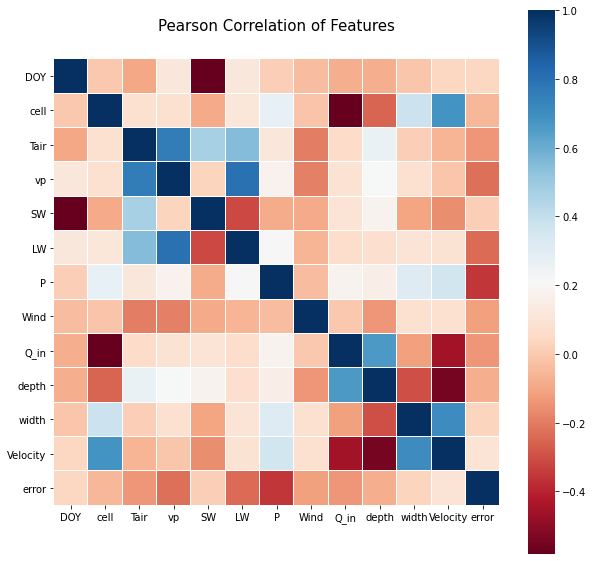

In [7]:
# Plotting the pearson correlation matrix of the features + traget
#Mapping commands
colormap = plt.cm.RdBu
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(final_df.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=False)
plt.show()

In [8]:
X = final_df.drop(columns=['error'])
Y = final_df['error']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [9]:
# Scaling the features using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [10]:
X_train = X_train_std
X_test = X_test_std

## Linear

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#Instantiate the model:
linear_model= LinearRegression()
#train the model using training data
linear_model.fit(X_train, y_train)

LinearRegression()

In [12]:
#Remember, in regression, the defauls score is R2
train_r2 = round(linear_model.score(X_train, y_train),2)
print('Training R2 score is {}'.format(train_r2))

Training R2 score is 0.37


In [13]:
#RMSE is a better measure for evuating the model on both trainin and testing data:
y_train_predicted = linear_model.predict(X_train)
#sklearn gives is mean_square_error. We need to take the square root to get RMSE
rmse_train_linear = (np.sqrt(mean_squared_error(y_train, y_train_predicted)))
print('RMSE of the linear model for the training set is {}'.format(rmse_train_linear))

RMSE of the linear model for the training set is 2.1001934828907904


In [14]:
y_pred = linear_model.predict(X_test)

rmse_test_linear = (np.sqrt(mean_squared_error(y_test, y_pred)))
print("RMSE of the linear model for the test set is {}".format(rmse_test_linear))

RMSE of the linear model for the test set is 2.121940482269274


In [15]:
linear_coefficients = pd.concat([pd.DataFrame(X.columns, columns={'feature'}),pd.DataFrame(np.transpose(linear_model.coef_), columns={'coefficient'})], axis = 1) 
linear_coefficients.sort_values(by='coefficient', ascending=False, inplace=True)
linear_coefficients

,feature,coefficient
11,Velocity,2.228234
9,depth,1.332577
2,Tair,0.516755
0,DOY,-0.033047
10,width,-0.183001
7,Wind,-0.427710
4,SW,-0.458509
3,vp,-0.476049
5,LW,-0.520193
8,Q_in,-0.680914


## Lasso

In [99]:
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso_params_grid = {'alpha':np.arange(0.001, 10, 0.05)}

lasso_cv =  RandomizedSearchCV(Lasso(), lasso_params_grid, cv=5, scoring ='neg_root_mean_squared_error', random_state=42)
lasso_cv.fit(X_train,y_train)
lasso_cv.best_params_

{'alpha': 0.751}

In [100]:
best_lasso = Lasso(alpha= 0.751)
best_lasso.fit(X_train, y_train)

Lasso(alpha=0.751)

In [101]:
# model evaluation for training set
train_r2_lasso = round(best_lasso.score(X_train, y_train),2)
print('Training R2 score is {}'.format(train_r2_lasso))
y_train_predicted_lasso = best_lasso.predict(X_train)
rmse_train_lasso = (np.sqrt(mean_squared_error(y_train, y_train_predicted_lasso)))
print('RMSE on the training set for the lasso model is: {}'.format(rmse_train_lasso))

Training R2 score is 0.05
RMSE on the training set for the lasso model is: 2.5775048173499626


In [102]:
# model evaluation for test set
y_test_predicted_lasso = best_lasso.predict(X_test)
rmse_test_lasso = (np.sqrt(mean_squared_error(y_test, y_test_predicted_lasso)))
print("RMSE on test set is for the lasso model is: {}".format(rmse_test_lasso))

RMSE on test set is for the lasso model is: 2.588280467783236


In [104]:
lasso_coefficients = pd.concat([pd.DataFrame(X.columns, columns={'feature'}),pd.DataFrame(np.transpose(best_lasso.coef_), columns={'coefficient'})], axis = 1) 
lasso_coefficients.sort_values(by='coefficient', ascending=False, inplace=True)
lasso_coefficients

,feature,coefficient
0,DOY,0.000000
1,cell,-0.000000
2,Tair,-0.000000
3,vp,-0.000000
4,SW,0.000000
5,LW,-0.000000
7,Wind,-0.000000
8,Q_in,-0.000000
9,depth,-0.000000
10,width,0.000000


## Ridge

In [105]:
from sklearn.linear_model import Ridge
ridge_params_grid = {'alpha':np.arange(0.001, 10, 0.05)} 
ridge_cv = RandomizedSearchCV(Ridge(), ridge_params_grid, cv=5, scoring ='neg_root_mean_squared_error', random_state=42)
ridge_cv.fit(X_train,y_train)
ridge_cv.best_params_

{'alpha': 0.751}

In [106]:
# create best_ridge and fit it to the training data
best_ridge = Ridge(alpha= 0.751)
best_ridge.fit(X_train,y_train)

Ridge(alpha=0.751)

In [107]:
# model evaluation for training set
train_r2_ridge = round(best_ridge.score(X_train, y_train),2)
print('Training R2 score is {}'.format(train_r2_ridge))
y_train_predicted_ridge = best_ridge.predict(X_train)
rmse_train_ridge = (np.sqrt(mean_squared_error(y_train, y_train_predicted_ridge)))
print('RMSE on the training set for the ridge model is: {}'.format(rmse_train_ridge))

Training R2 score is 0.37
RMSE on the training set for the ridge model is: 2.100193519168613


In [108]:
# model evaluation for test set
y_test_predicted_ridge = best_ridge.predict(X_test)
rmse_test_ridge = (np.sqrt(mean_squared_error(y_test, y_test_predicted_ridge)))
print("RMSE on testing set is for the ridge model is: {}".format(rmse_test_ridge))

RMSE on testing set is for the ridge model is: 2.1219425320164746


In [109]:
ridge_coefficients = pd.concat([pd.DataFrame(X.columns, columns={'variable'}),pd.DataFrame(np.transpose(best_ridge.coef_), columns={'coefficient'})], axis = 1) 
ridge_coefficients.sort_values(by='coefficient', ascending=False, inplace=True)
ridge_coefficients

,variable,coefficient
11,Velocity,2.227441
9,depth,1.332113
2,Tair,0.516368
0,DOY,-0.032860
10,width,-0.182777
7,Wind,-0.427706
4,SW,-0.458082
3,vp,-0.476052
5,LW,-0.519870
8,Q_in,-0.680670


## Random Forest Regression

In [110]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(random_state=42)


rf_params = {'max_depth':np.arange(1,10,1),
             'min_samples_split':np.arange(2,50,1),
             'min_samples_leaf':np.arange(2,50,1),
             'max_features':['sqrt', 'log2']} # could also add 'criterion':['mse', 'mae'],

#TODO: find optimal parameters for random forest regressor using  RandomizedSearchCV. Set random_state=42 and be careful about scoring type
rf_regressor_cv = RandomizedSearchCV(rf_regressor, rf_params, cv=5, scoring='neg_root_mean_squared_error', random_state=42)


rf_regressor_cv.fit(X_train, y_train)
rf_regressor_cv.best_params_

{'min_samples_split': 44,
 'min_samples_leaf': 8,
 'max_features': 'sqrt',
 'max_depth': 9}

In [111]:
np.random.seed(42)

# create best_rf_regressor sunig the parameters above and fit it to training data
best_rf_regressor = RandomForestRegressor(max_depth= 9, max_features = 'sqrt', min_samples_leaf= 8, min_samples_split=44)
best_rf_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, max_features='sqrt', min_samples_leaf=8,
                      min_samples_split=44)

In [112]:
# model evaluation for training set
train_r2_rf = round(best_rf_regressor.score(X_train, y_train),2)
print('Training R2 score of Random Forest is {}'.format(train_r2_rf))
y_train_predicted_rf = best_rf_regressor.predict(X_train)
rmse_train_rf = (np.sqrt(mean_squared_error(y_train, y_train_predicted_rf)))
print('RMSE on the training set for the Random Forest model is: {}'.format(rmse_train_rf))

Training R2 score of Random Forest is 0.83
RMSE on the training set for the Random Forest model is: 1.1021207361414642


In [113]:
# model evaluation for test set
y_test_predicted_rf = best_rf_regressor.predict(X_test)
rmse_test_rf= (np.sqrt(mean_squared_error(y_test, y_test_predicted_rf)))
print("RMSE on testing set is for the Random Forest model is: {}".format(rmse_test_rf))

RMSE on testing set is for the Random Forest model is: 1.1371942432036102


In [114]:
rf_importance = pd.concat([pd.DataFrame(X.columns, columns={'feature'}),pd.DataFrame(np.transpose(best_rf_regressor.feature_importances_), columns={'Importance'})], axis = 1) 
rf_importance.sort_values(by='Importance', ascending=False, inplace=True)
rf_importance

,feature,Importance
1,cell,0.392220
6,P,0.190739
0,DOY,0.109522
8,Q_in,0.078173
2,Tair,0.058250
3,vp,0.041467
5,LW,0.036929
4,SW,0.025696
10,width,0.023649
9,depth,0.015938


## Support Vector Machines

In [18]:
from sklearn.svm import SVR
svr = SVR()

svr_params = { 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': ['scale', 'auto'],
              'C': np.arange(0.1, 5,0.4)}

svr_cv = RandomizedSearchCV(svr, svr_params, cv=5, scoring='neg_root_mean_squared_error', random_state=42)
svr_cv.fit(X_train, y_train)
svr_cv.best_params_

KeyboardInterrupt: 

In [ ]:
# create best_svr and fit it to training data
best_svr = SVR(C= 0.1, gamma= 'scale', kernel= 'linear')
best_svr.fit(X_train, y_train)

In [ ]:
# model evaluation for training set
train_r2_svr = round(best_svr.score(X_train, y_train),2)
print('Training R2 score of SVM Regressor is {}'.format(train_r2_svr))
y_train_predicted_svr = best_svr.predict(X_train)
rmse_train_svr = (np.sqrt(mean_squared_error(y_train, y_train_predicted_svr)))
print('RMSE on the training set for the SVM Regressor is: {}'.format(rmse_train_svr))

In [ ]:
# model evaluation for test set
y_test_predicted_svr = best_svr.predict(X_test)
rmse_test_svr= (np.sqrt(mean_squared_error(y_test, y_test_predicted_svr)))
print("RMSE on testing set is for the SVM Regressor is: {}".format(rmse_test_svr))

In [ ]:
svm_coefficients = pd.concat([pd.DataFrame(X.columns, columns={'variable'}),pd.DataFrame(np.transpose(best_svr.coef_), columns={'coefficient'})], axis = 1) 
svm_coefficients.sort_values(by='coefficient', ascending=False, inplace=True)
svm_coefficients

## Gradient Boosting

In [87]:
from sklearn.model_selection import RandomizedSearchCV

In [88]:
from sklearn.ensemble import GradientBoostingRegressor

gb_regressor = GradientBoostingRegressor(random_state=42)
 
gb_params = dict(learning_rate=np.arange(0.05,0.3,0.05), 
                     n_estimators=np.arange(100,1000,100), 
                     subsample = np.arange(0.1,0.9,0.05),
                     max_depth=[int(i) for i in np.arange(1,10,1)],
                     max_features = ['sqrt', 'log2']) 

gb_cv = RandomizedSearchCV(gb_regressor, gb_params, random_state=42, cv=5, scoring='neg_root_mean_squared_error')
gb_optimized = gb_cv.fit(X_train, y_train)
print('best params: ', gb_optimized.best_params_)

best params:  {'subsample': 0.6000000000000002, 'n_estimators': 700, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.1}


In [89]:
np.random.seed(42)
best_gbr = GradientBoostingRegressor(subsample= 0.6000000000000002, n_estimators= 700, max_features= 'sqrt', max_depth= 7, learning_rate= 0.1)
best_gbr.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=7, max_features='sqrt', n_estimators=700,
                          subsample=0.6000000000000002)

In [91]:
from sklearn.metrics import mean_squared_error
# model evaluation for training set
train_r2_gbr = round(best_gbr.score(X_train, y_train),2)
print('Training R2 score of Gradient Boosting Regressor is {}'.format(train_r2_gbr))
y_train_predicted_gbr = best_gbr.predict(X_train)
rmse_train_gbr = (np.sqrt(mean_squared_error(y_train, y_train_predicted_gbr)))
print('RMSE on the training set for the Gradient Boosting Regressor is: {}'.format(rmse_train_gbr))

Training R2 score of Gradient Boosting Regressor is 1.0
RMSE on the training set for the Gradient Boosting Regressor is: 0.17488056347431297


In [92]:
# model evaluation for test set
y_test_predicted_gbr = best_gbr.predict(X_test)
rmse_test_gbr= (np.sqrt(mean_squared_error(y_test, y_test_predicted_gbr)))
print("RMSE on testing set is for the Gradient Boosting Regressor is: {}".format(rmse_test_gbr))

RMSE on testing set is for the Gradient Boosting Regressor is: 0.5380514142371875


In [93]:
gbr_importance = pd.concat([pd.DataFrame(X.columns, columns={'variable'}),pd.DataFrame(np.transpose(best_gbr.feature_importances_), columns={'Importance'})], axis = 1) 
gbr_importance.sort_values(by='Importance', ascending=False, inplace=True)
gbr_importance

,variable,Importance
1,cell,0.316024
6,P,0.191479
0,DOY,0.128621
2,Tair,0.069909
8,Q_in,0.054470
3,vp,0.052430
5,LW,0.051937
4,SW,0.049150
7,Wind,0.027460
10,width,0.023967


## Ada Boost

In [20]:
from sklearn.ensemble import AdaBoostRegressor

adaboost = AdaBoostRegressor(random_state=42)

# defiene a dictionary of Adaboost hyperparameters. Find best values using RandomizedSearchCV, and fit it to training data

#A dictionary with parameters names as keys and distributions or lists of parameter as values 
adaboost_params = dict(learning_rate=np.arange(0.01,1.0,0.05), 
                 n_estimators=np.arange(10,200,10),
                 loss = ['linear', 'square', 'exponential'])
adaboost_cv = RandomizedSearchCV(adaboost, adaboost_params, random_state=42, cv=5, scoring='neg_root_mean_squared_error')
adaboost_optimized = adaboost_cv.fit(X_train, y_train)
print('best params: ', adaboost_optimized.best_params_)

best params:  {'n_estimators': 130, 'loss': 'linear', 'learning_rate': 0.9600000000000001}


In [21]:
# create best_adaboost using what you found above and fit it to training data
best_adaboost = AdaBoostRegressor(n_estimators = 130, random_state=42, learning_rate=0.96, loss='linear')
best_adaboost.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.96, n_estimators=130, random_state=42)

In [22]:
# model evaluation for training set
train_r2_adaboost = round(best_adaboost.score(X_train, y_train),2)
print('Training R2 score of Adaboost Regressor is {}'.format(train_r2_adaboost))
y_train_predicted_adaboost = best_adaboost.predict(X_train)
rmse_train_adaboost = (np.sqrt(mean_squared_error(y_train, y_train_predicted_adaboost)))
print('RMSE on the training set for the Adaboost Regressor is: {}'.format(rmse_train_adaboost))

Training R2 score of Adaboost Regressor is 0.6
RMSE on the training set for the Adaboost Regressor is: 1.6748330719890472


In [23]:
# model evaluation for test set
y_test_predicted_adaboost = best_adaboost.predict(X_test)
rmse_test_adaboost= (np.sqrt(mean_squared_error(y_test, y_test_predicted_adaboost)))
print("RMSE on testing set is for the Adaboost Regressor is: {}".format(rmse_test_adaboost))

RMSE on testing set is for the Adaboost Regressor is: 1.6935297662839623
